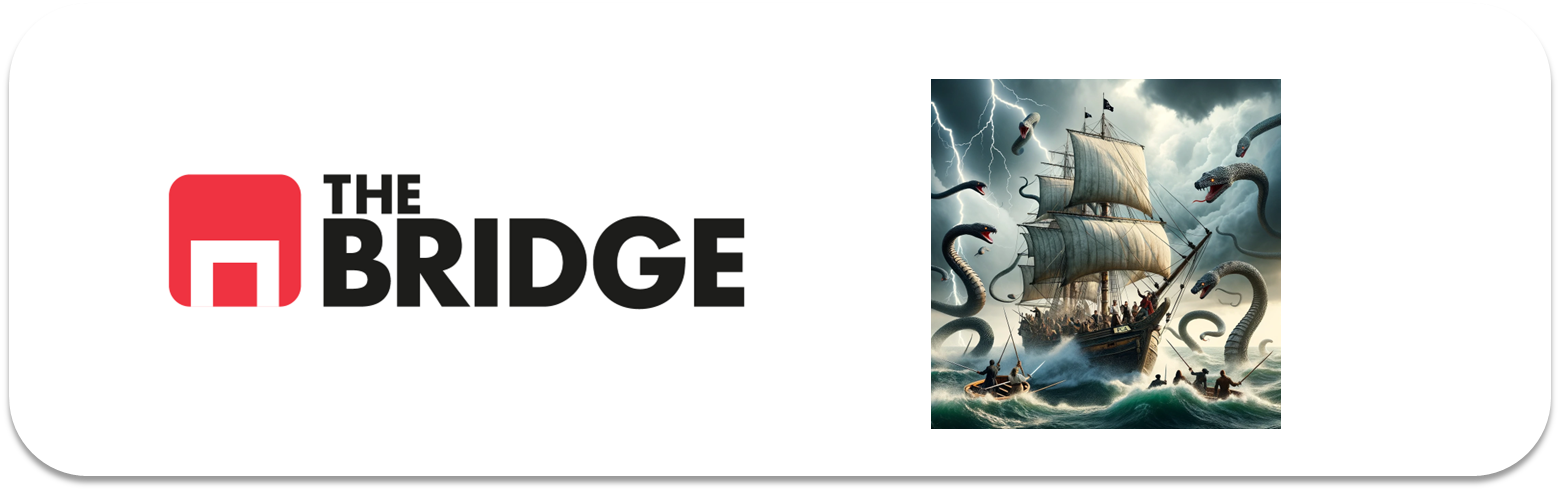

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../../..") # Añadimos al path la carpeta que está 2 niveles arriba
import toolkit as tk

sys.path.append("../../../Team_Challenge_SP10_T03")
import toolbox_ML as tb

from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector

from sklearn.metrics import mutual_info_score, classification_report, balanced_accuracy_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificación sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [107]:
df = pd.read_csv("credit_npo.csv")

In [108]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [87]:
tb.describe_df(df).T

,DATE_TYPE,MISSINGS(%),UNIQUE_VALUES,CARDIN(%)
COL_N,,,,
SeriousDlqin2yrs,int64,0.0,2,0.02
RevolvingUtilizationOfUnsecuredLines,float64,0.0,10764,85.86
age,int64,0.0,78,0.62
NumberOfTime30-59DaysPastDueNotWorse,int64,0.0,10,0.08
DebtRatio,float64,0.0,11547,92.1
MonthlyIncome,float64,5.75,4167,33.24
NumberOfOpenCreditLinesAndLoans,int64,0.0,43,0.34
NumberOfTimes90DaysLate,int64,0.0,13,0.1
NumberRealEstateLoansOrLines,int64,0.0,16,0.13


In [109]:
df.dropna(inplace=True)

In [6]:
tb.tipifica_variables(df)

,nombre_variable,dtype,tipo_sugerido
0,SeriousDlqin2yrs,int64,Binaria
1,RevolvingUtilizationOfUnsecuredLines,float64,Numerica continua
2,age,int64,Numerica discreta
3,NumberOfTime30-59DaysPastDueNotWorse,int64,Numerica discreta
4,DebtRatio,float64,Numerica continua
5,MonthlyIncome,float64,Numerica continua
6,NumberOfOpenCreditLinesAndLoans,int64,Numerica discreta
7,NumberOfTimes90DaysLate,int64,Numerica discreta
8,NumberRealEstateLoansOrLines,int64,Numerica discreta
9,NumberOfTime60-89DaysPastDueNotWorse,int64,Categorica


In [7]:
df.describe()

COL_N,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000,11816.000000
mean,0.070244,0.335668,51.447698,0.340471,0.499708,6864.815420,8.759140,0.180010,1.059580,0.149712,0.856804
std,0.255568,0.365209,14.516270,2.927409,2.696067,11855.905437,5.129772,2.892577,1.140716,2.868248,1.147509
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.034927,41.000000,0.000000,0.143456,3498.750000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.179183,51.000000,0.000000,0.294748,5416.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.587187,62.000000,0.000000,0.477414,8300.000000,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,6.000000,101.000000,98.000000,96.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


In [110]:
target = "SeriousDlqin2yrs"

In [9]:
features_cat = ["NumberOfTime60-89DaysPastDueNotWorse"]

In [10]:
features_num = ["RevolvingUtilizationOfUnsecuredLines", "age", "NumberOfTime30-59DaysPastDueNotWorse", \
                "DebtRatio", "MonthlyIncome", "NumberOfOpenCreditLinesAndLoans", "NumberOfTimes90DaysLate", \
                "NumberRealEstateLoansOrLines", "NumberOfDependents"]

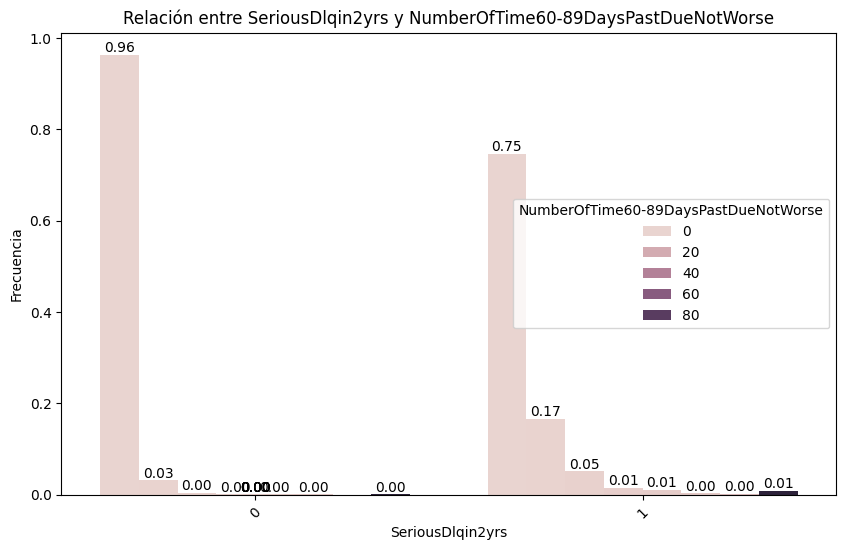

In [11]:
for cat in features_cat:
    tk.plot_categorical_relationship_fin(df, target, cat, show_values=True, relative_freq=True)

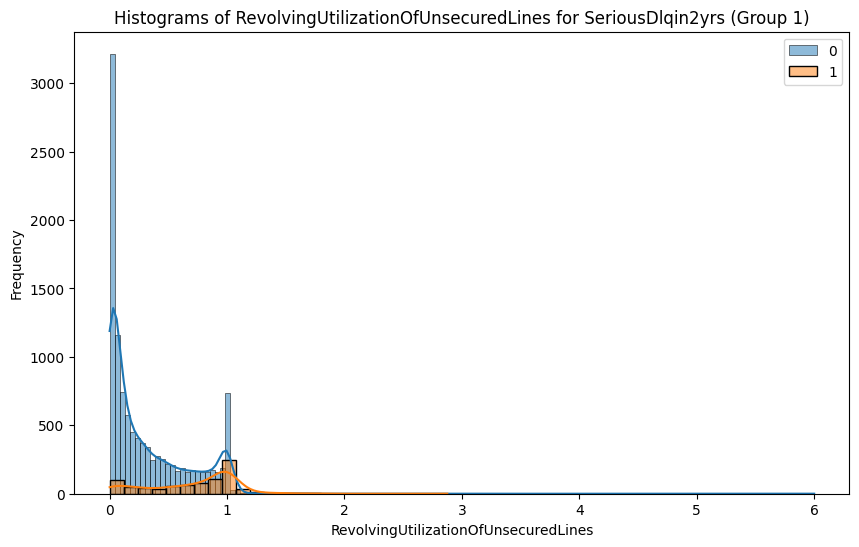

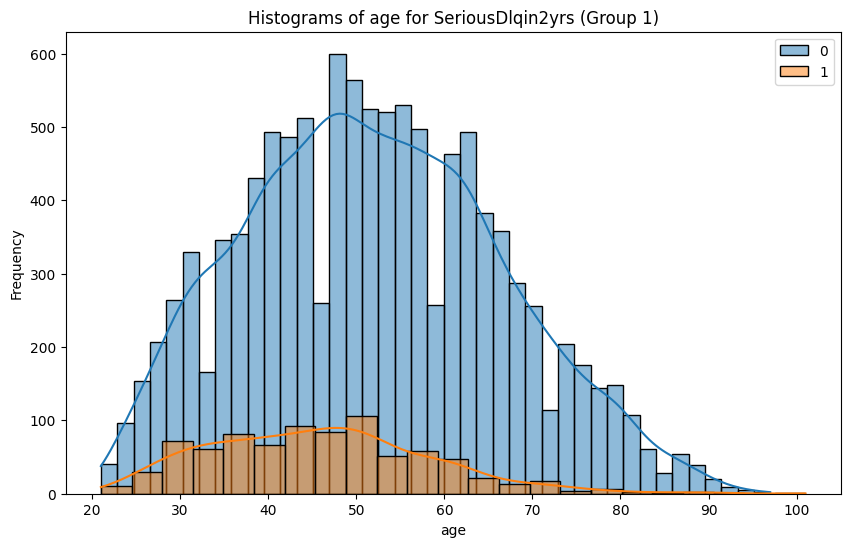

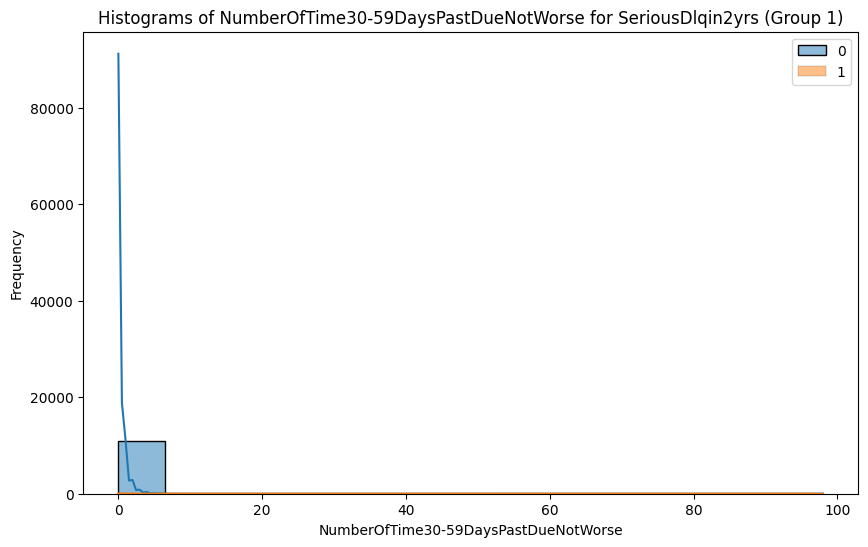

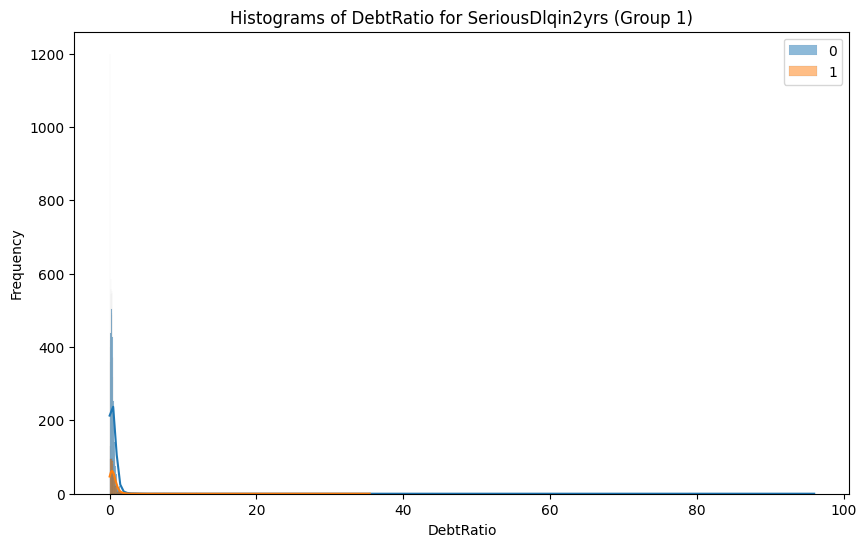

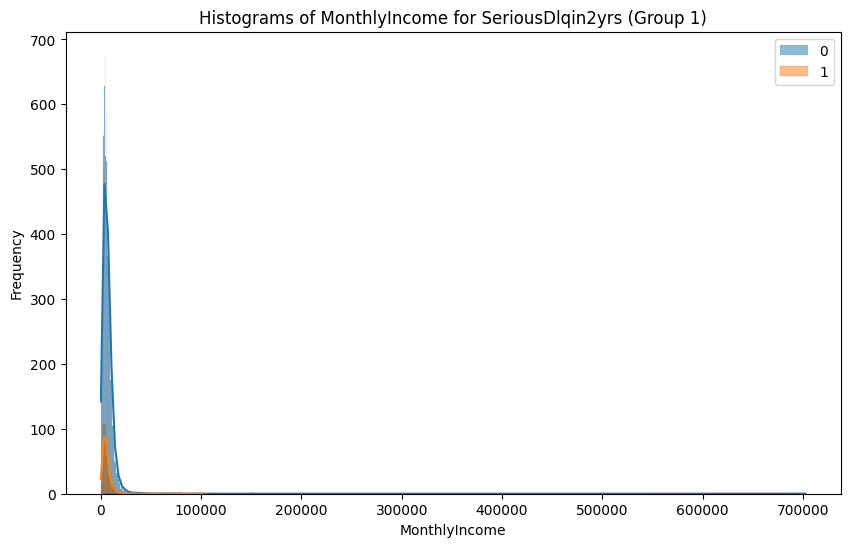

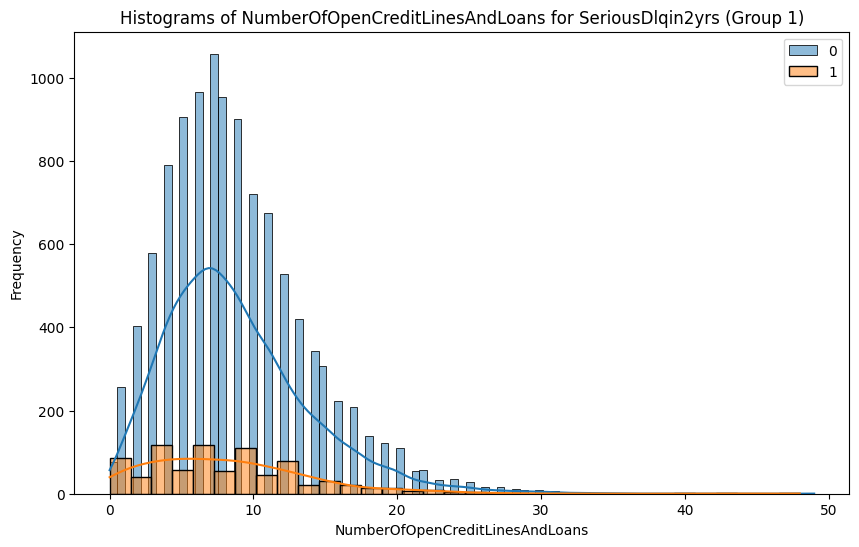

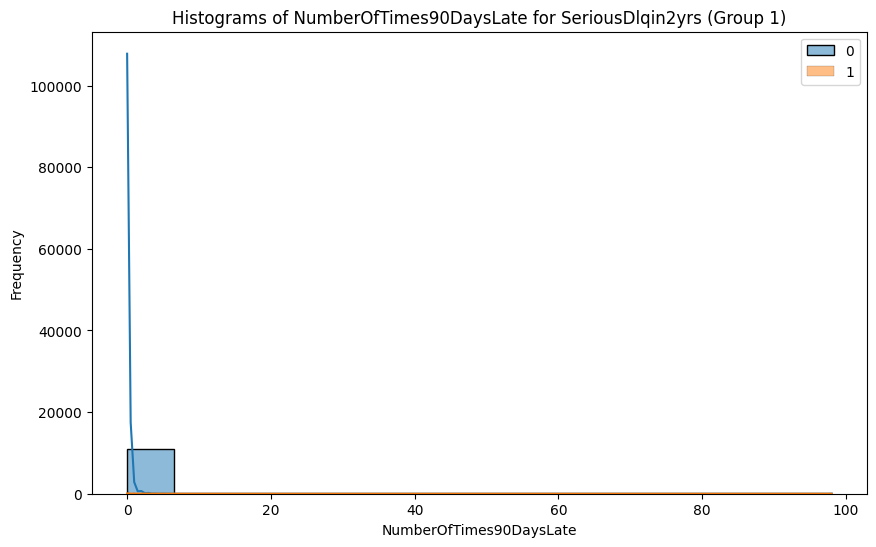

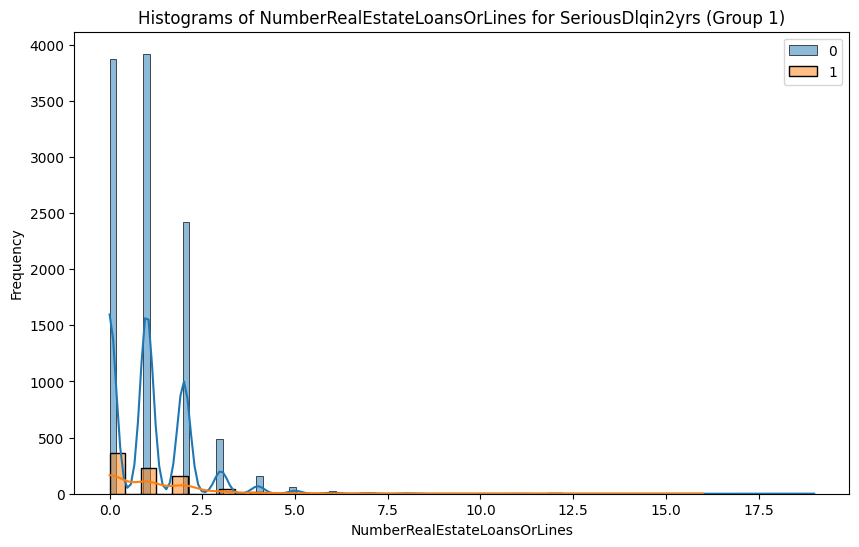

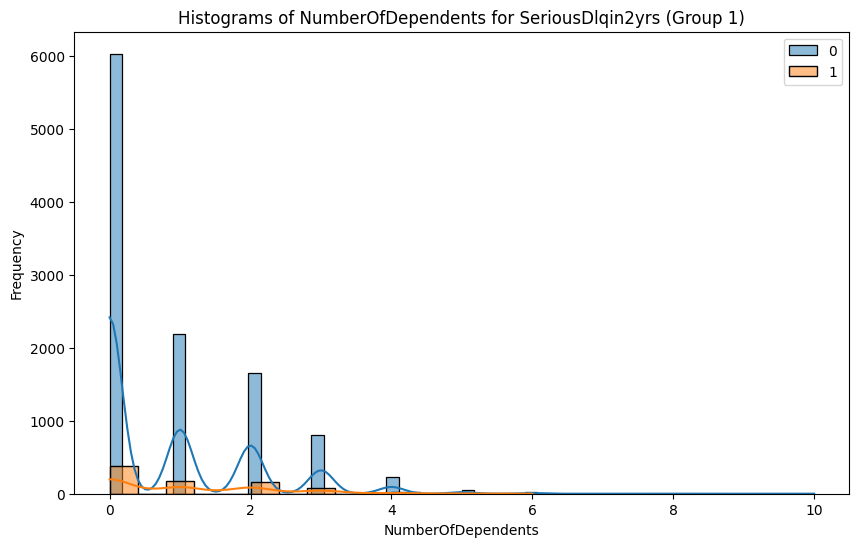

In [12]:
for num in features_num:
    tk.plot_grouped_histograms(df, cat_col=target, num_col=num, group_size=2)

In [13]:
# plt.figure(figsize=(20, 10))  # 12 pulgadas de ancho, 6 de alto

# # Crear el histograma
# ax = df["NumberRealEstateLoansOrLines"].hist()

# # Ajustar los ticks del eje X cada 1 unidades
# min_val = 0  
# max_val = df["NumberRealEstateLoansOrLines"].max()
# ticks = np.arange(min_val, max_val + 1, 1)  
# ax.set_xticks(ticks)

# # Etiquetas y título
# plt.xlabel("Número")
# plt.ylabel("Frecuencia")
# plt.title("Histograma de NumberRealEstateLoansOrLines")

# # Mostrar el gráfico
# plt.show()

In [14]:
# df["NumberRealEstateLoansOrLines_bin"] = pd.cut(df["NumberRealEstateLoansOrLines"], bins=[0,1,4,20], labels=["0-1","1-4","+4"], include_lowest=True)

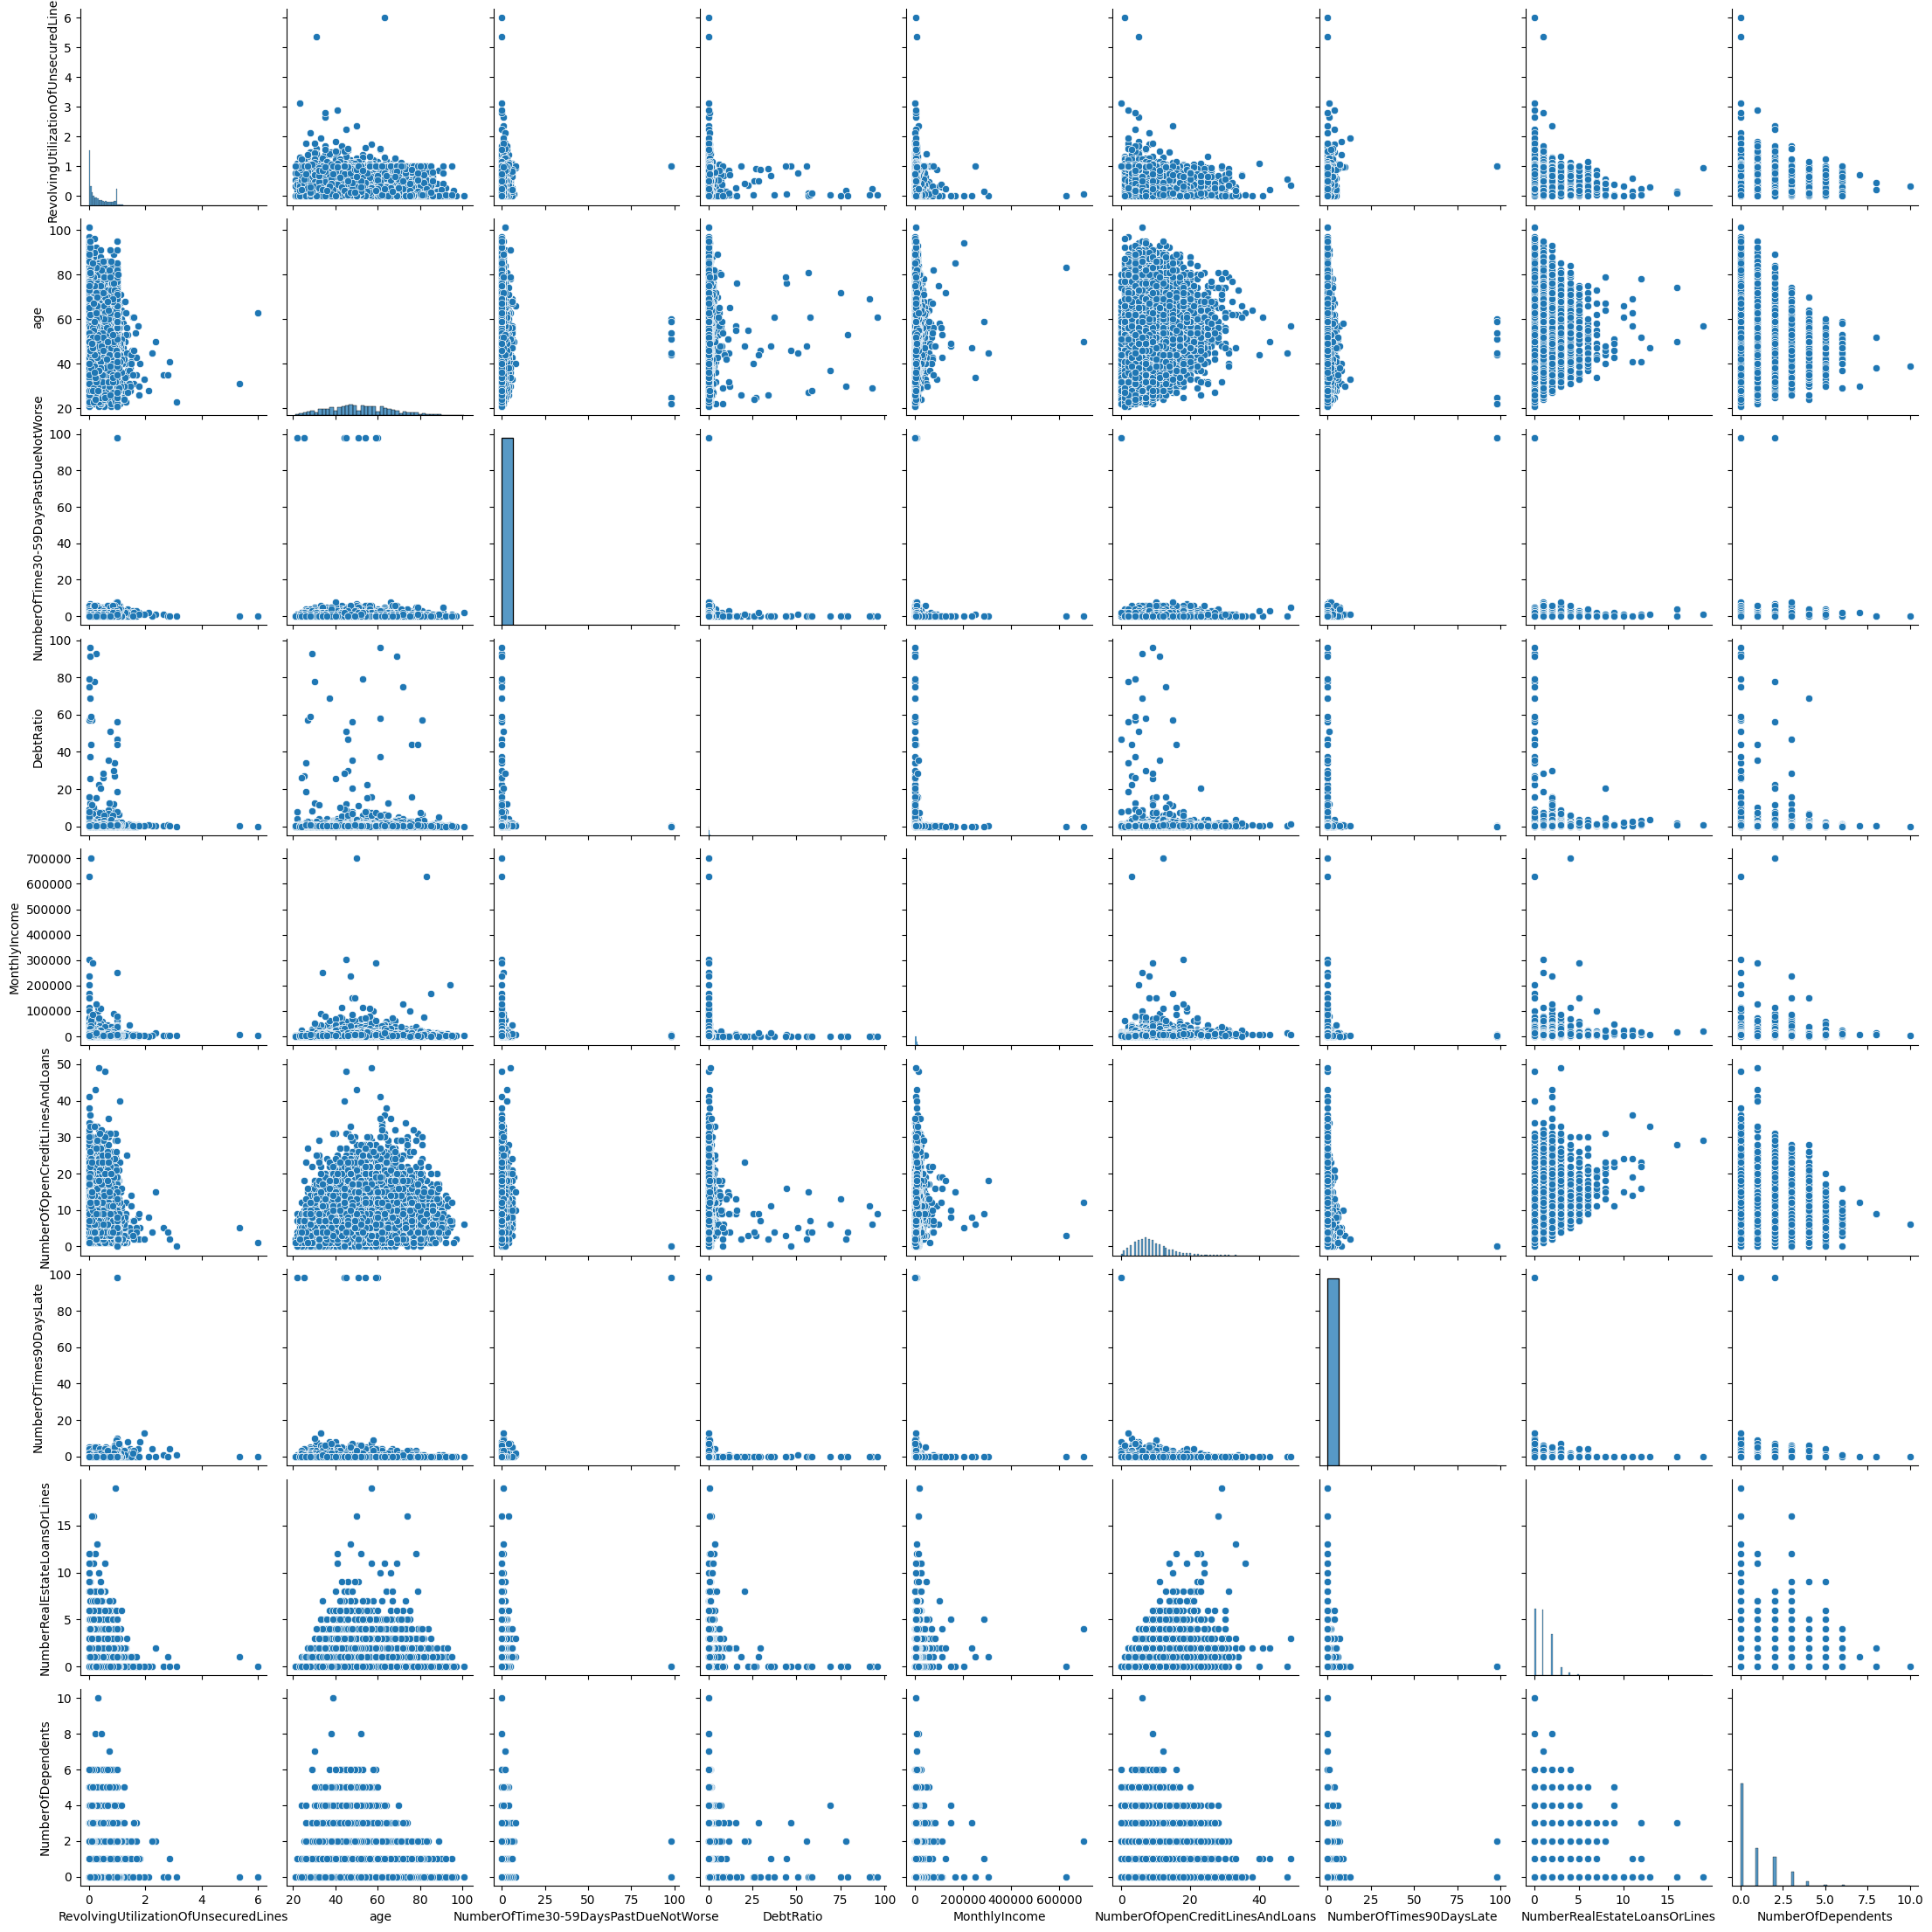

In [15]:
sns.pairplot(df[features_num])

##### Categórica - Categórica -> Chi2

In [16]:
cat_1 = "NumberOfTime60-89DaysPastDueNotWorse"

tabla_contingencia = pd.crosstab(df[target], df[cat_1])

chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)

Valor Chi-Cuadrado: 875.367228205803
P-Value: 1.0005254352338968e-184
Grados de Libertad: 7
Tabla de Frecuencias Esperadas:
 [[1.04188487e+04 4.44423494e+02 7.90292823e+01 1.67356127e+01
  1.30165877e+01 3.71902505e+00 9.29756263e-01 9.29756263e+00]
 [7.87151320e+02 3.35765064e+01 5.97071767e+00 1.26438727e+00
  9.83412322e-01 2.80974949e-01 7.02437373e-02 7.02437373e-01]]


*Existe dependencia aunque en el análisis visual no se apreciaba*

##### CATEGÓRICA (BINARIA) - NUMÉRICA -> ANOVA

In [17]:
df[target].value_counts()

SeriousDlqin2yrs
0    10986
1      830
Name: count, dtype: int64

In [18]:
for num in features_num:
    grupo_a = df.loc[df[target] == 0][num]
    grupo_b = df.loc[df[target] == 1][num]
    
    u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

    print(f"{target} - {num}")
    print("Estadístico U:", u_stat)
    print("Valor p:", p_valor)
    print("----------------")

SeriousDlqin2yrs - RevolvingUtilizationOfUnsecuredLines
Estadístico U: 2041447.0
Valor p: 1.268703615167389e-155
----------------
SeriousDlqin2yrs - age
Estadístico U: 5671012.5
Valor p: 8.383021088623333e-32
----------------
SeriousDlqin2yrs - NumberOfTime30-59DaysPastDueNotWorse
Estadístico U: 2952171.5
Valor p: 2.9253455520343597e-149
----------------
SeriousDlqin2yrs - DebtRatio
Estadístico U: 4073782.5
Valor p: 3.014368098116093e-07
----------------
SeriousDlqin2yrs - MonthlyIncome
Estadístico U: 5181487.5
Valor p: 5.1247707005958374e-11
----------------
SeriousDlqin2yrs - NumberOfOpenCreditLinesAndLoans
Estadístico U: 4957010.0
Valor p: 2.578979534509943e-05
----------------
SeriousDlqin2yrs - NumberOfTimes90DaysLate
Estadístico U: 3124875.0
Valor p: 0.0
----------------
SeriousDlqin2yrs - NumberRealEstateLoansOrLines
Estadístico U: 4800066.5
Valor p: 0.007379119141377314
----------------
SeriousDlqin2yrs - NumberOfDependents
Estadístico U: 4109382.5
Valor p: 1.8231822357540615e-

*Existe dependencia entre todas las variables y el target, aunque en el análisis visual no se apreciaba*

#### UMBRAL DE COVARIANZA

In [19]:
umbral_varianza = 0.5

var_selector = VarianceThreshold(umbral_varianza)
var_selector.fit(df.drop(columns=target))
print("Lista seleccionada para selector de Varianza", var_selector.get_feature_names_out())

Lista seleccionada para selector de Varianza ['age' 'NumberOfTime30-59DaysPastDueNotWorse' 'DebtRatio' 'MonthlyIncome'
 'NumberOfOpenCreditLinesAndLoans' 'NumberOfTimes90DaysLate'
 'NumberRealEstateLoansOrLines' 'NumberOfTime60-89DaysPastDueNotWorse'
 'NumberOfDependents']


*Según el umbral de varianza la única que no tendría relación con el target sería la variable "RevolvingUtilizationOfUnsecuredLines"*

#### ANOVA Y SELECT K BEST

In [20]:
'''
f_classif realiza un test ANOVA
La técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930,
constituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre
la media de una variable continua. Es por lo tanto el test estadístico a emplear cuando se desea comparar las medias de
dos o más grupos.
'''

selector = SelectKBest(f_classif, k=6)
x_data_kbest = selector.fit_transform(df[features_num], df[target])

In [21]:
first_division_selectkbest = selector.get_feature_names_out().tolist()

In [22]:
first_division_selectkbest

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberOfDependents']

##### Mutual Information

In [23]:
for cat in features_cat:
    print(f"MI({cat};{target}):", mutual_info_score(df[cat],df[target]))

MI(NumberOfTime60-89DaysPastDueNotWorse;SeriousDlqin2yrs): 0.01984855135498301


In [24]:
first_division_mutual = features_cat

In [25]:
first_division_mutual

['NumberOfTime60-89DaysPastDueNotWorse']

#### MODELO

In [26]:
rf = RandomForestClassifier(random_state= 42)

In [27]:
rf.fit(df[features_num],df[target])

RandomForestClassifier(random_state=42)

In [28]:
rf.feature_importances_[rf.feature_importances_ > rf.feature_importances_.mean()]

array([0.20303433, 0.12305182, 0.16291081, 0.15611011, 0.11291781])

In [29]:
selector_model = SelectFromModel(estimator = rf, threshold= "median") # El modelo debe tener un atributo feature_importances_ o un atributo coef_

In [30]:
selector_model.fit(df[features_num],df[target]) 

SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median')

In [31]:
first_division_model = selector_model.get_feature_names_out().tolist()

In [32]:
first_division_model

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfTimes90DaysLate']

#### WRAPPER -> RFE

In [33]:
rf_RFE = RandomForestClassifier(random_state= 42) # Puedes usar tu modelo, o modelos a probar o un modelo "proxy" como en la selección por modelo

rfe = RFE(estimator = rf_RFE,
          n_features_to_select= 6, # Iterará hasta quedarse con 6
          step = 1) # Elimina de una en una, pero es configurable

rfe.fit(df[features_num], df[target])
print(rfe.ranking_)

[1 1 2 1 1 1 1 4 3]


In [34]:
first_division_rfe = rfe.get_feature_names_out().tolist()

In [35]:
first_division_rfe

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate']

#### WRAPPER -> SFS

In [36]:
rf_SFS = RandomForestClassifier(random_state = 42)

sfs_forward = SequentialFeatureSelector(rf_SFS,
                                        n_features_to_select = 6,
                                        cv = 5,
                                        scoring = "balanced_accuracy")


sfs_forward.fit(df[features_num], df[target])

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=6, scoring='balanced_accuracy')

In [37]:
print("Elegidasd SFS:", sfs_forward.get_feature_names_out())

Elegidasd SFS: ['RevolvingUtilizationOfUnsecuredLines' 'age'
 'NumberOfOpenCreditLinesAndLoans' 'NumberOfTimes90DaysLate'
 'NumberRealEstateLoansOrLines' 'NumberOfDependents']


In [38]:
first_division_sfs = sfs_forward.get_feature_names_out().tolist()

In [39]:
first_division_sfs

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfDependents']

#### MODELADO

In [ ]:
f = df.columns.tolist()
f.remove(target)

In [117]:
scaler = StandardScaler()

scaler.fit(df[f])

StandardScaler()

In [119]:
df[f] = scaler.transform(df[f])

In [120]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,11816.000000,1.181600e+04,1.181600e+04,1.181600e+04,1.181600e+04,1.181600e+04,1.181600e+04,1.181600e+04,1.181600e+04,1.181600e+04,1.181600e+04
mean,0.070244,-2.525626e-17,2.360257e-17,2.946563e-17,2.826296e-17,-3.307367e-17,1.082411e-16,7.817413e-18,4.810716e-18,-1.683751e-17,-5.652591e-17
std,0.255568,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00
min,0.000000,-9.191523e-01,-2.097576e+00,-1.163093e-01,-1.853549e-01,-5.790453e-01,-1.707583e+00,-6.223439e-02,-9.289126e-01,-5.219863e-02,-7.466963e-01
25%,0.000000,-8.235125e-01,-7.197538e-01,-1.163093e-01,-1.321432e-01,-2.839267e-01,-7.328395e-01,-6.223439e-02,-9.289126e-01,-5.219863e-02,-7.466963e-01
50%,0.000000,-4.284995e-01,-3.084243e-02,-1.163093e-01,-7.602491e-02,-1.222072e-01,-1.479934e-01,-6.223439e-02,-5.223279e-02,-5.219863e-02,-7.466963e-01
75%,0.000000,6.887255e-01,7.269600e-01,-1.163093e-01,-8.269590e-03,1.210574e-01,4.368527e-01,-6.223439e-02,8.244471e-01,-5.219863e-02,9.962835e-01
max,1.000000,1.551049e+01,3.413714e+00,3.336181e+01,3.542358e+01,5.867663e+01,7.844903e+00,3.381902e+01,1.572800e+01,3.411645e+01,7.968203e+00


In [130]:
first_division_selectkbest_con_cat = first_division_selectkbest + first_division_mutual
first_division_model_con_cat = first_division_model + first_division_mutual
first_division_rfe_con_cat = first_division_rfe + first_division_mutual
first_division_sfs_con_cat = first_division_sfs + first_division_mutual

In [131]:
model_names = ["KNN_3", "KNN_5", "Logistic Regression", "DecisionTree", "Random Forest", "XGBoost", "LightGBM"]

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state= 42)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)

model_set = [knn_3, knn_5, lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf]

In [132]:
lista_first_division = []
lista_first_division.append(first_division_selectkbest_con_cat)
lista_first_division.append(first_division_model_con_cat)
lista_first_division.append(first_division_rfe_con_cat)
lista_first_division.append(first_division_sfs_con_cat)

In [133]:
lista_names = ["first_division_selectkbest_con_cat", "first_division_model_con_cat", "first_division_rfe_con_cat", "first_division_sfs_con_cat"]

In [137]:
metricas_cv = {}
valores = []

for names, lista in zip(lista_names, lista_first_division):
    for nombre, modelo in zip(model_names, model_set):
        print(modelo)
        if nombre != "Logistic Regression":
            metricas_cv[f"{nombre}_{names}"] = cross_val_score(modelo, df[lista], df[target], cv = 5, scoring = "balanced_accuracy")
        else:
            metricas_cv[f"{nombre}_{names}"] = cross_val_score(modelo, df[lista], df[target], cv = 5, scoring = "balanced_accuracy")
        valores.append(np.mean(metricas_cv[f"{nombre}_{names}"]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

KNeighborsClassifier(n_neighbors=3)
KNeighborsClassifier()
LogisticRegression(max_iter=10000)
DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(random_state=42, verbose=-100)
KNeighborsClassifier(n_n

In [138]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Balanced_accuracy: {np.mean(valores)}")
print("--------------------")
print(f"El ganador es {ganador}")

Model <KNN_3_first_division_selectkbest_con_cat>, Balanced_accuracy: 0.5759066827637042
Model <KNN_5_first_division_selectkbest_con_cat>, Balanced_accuracy: 0.5612477875850516
Model <Logistic Regression_first_division_selectkbest_con_cat>, Balanced_accuracy: 0.5274591724329468
Model <DecisionTree_first_division_selectkbest_con_cat>, Balanced_accuracy: 0.6224620468552213
Model <Random Forest_first_division_selectkbest_con_cat>, Balanced_accuracy: 0.6008677804226107
Model <XGBoost_first_division_selectkbest_con_cat>, Balanced_accuracy: 0.6047659901811517
Model <LightGBM_first_division_selectkbest_con_cat>, Balanced_accuracy: 0.598583956630472
Model <KNN_3_first_division_model_con_cat>, Balanced_accuracy: 0.5908518233358998
Model <KNN_5_first_division_model_con_cat>, Balanced_accuracy: 0.5838423112533688
Model <Logistic Regression_first_division_model_con_cat>, Balanced_accuracy: 0.5276867555007666
Model <DecisionTree_first_division_model_con_cat>, Balanced_accuracy: 0.601798094106513
Mod

#### OPTIMIZACIÓN DE HIPERPARÁMETROS

In [139]:
params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 5,
                       scoring = "balanced_accuracy",
                       n_jobs = -1)

rf_grid.fit(df[first_division_selectkbest_con_cat], df[target])

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='balanced_accuracy')

In [140]:
rf_grid.best_score_

np.float64(0.5943348632165558)

In [141]:
rf_grid.best_params_

{'max_depth': 2,
 'max_features': None,
 'max_samples': 0.6,
 'min_samples_leaf': 40,
 'n_estimators': 200}

In [143]:
tk.metrics_evaluation(rf_grid, df[first_division_selectkbest_con_cat], df[target])

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10986
           1       0.62      0.20      0.30       830

    accuracy                           0.94     11816
   macro avg       0.78      0.60      0.63     11816
weighted avg       0.92      0.94      0.92     11816



### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.